## Notebook to practice building a clustering, segmentation, and prediction model from transaction level data

#### The following code uses the "black Friday" data set which can be downloaded open source from Kaggle.com uder the url https://www.kaggle.com/mehdidag/black-friday 

### The purpose is to first gain an understanding of the data within the data set and next to build a segmentation and prediction model which will help the retailor to both identify and capture more of their best customers.

In [402]:
import pandas as pd
import numpy as np
data = pd.read_csv(r"C:\Users\Duncan C-S\Documents\Jupyter Notebooks\Black Friday DataSet\BlackFriday.csv")

#### The data contains 537'577 rows of customer transactions from 5'891 Customers.
The data includes personal demographic data as well as transaction item data such as item cost, and product category.

In [407]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


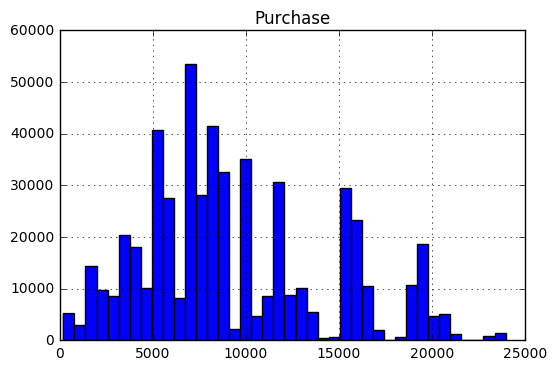

In [408]:
import matplotlib.pyplot as plt
data.hist(column = 'Purchase', bins = 40)
plt.show()

In [61]:
transaction_columns = ['Product_ID', 'Product_Category_1','Product_Category_2','Product_Category_3', 'Purchase', 'index']
pers = data.drop_duplicates(subset='User_ID', keep = 'first').reset_index()
pers = pers.drop(labels = transaction_columns, axis = 1)
pers.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status
0,1000001,F,0-17,10,A,2,0
1,1000002,M,55+,16,C,4+,0
2,1000003,M,26-35,15,A,3,0
3,1000004,M,46-50,7,B,2,1
4,1000005,M,26-35,20,A,1,1


#### The above table agregates the personal info of each User_ID and drops the data related to transactions

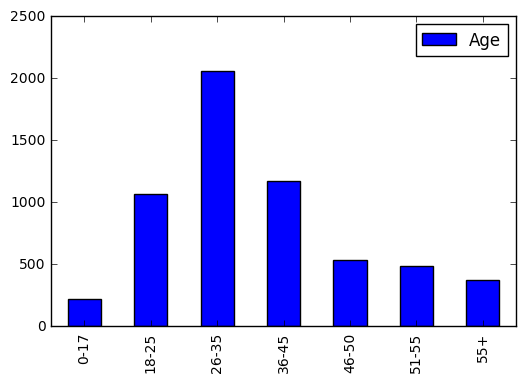

In [90]:
Age_plot = pers['Age'].value_counts().to_frame()
Age_plot['new_index'] = [2, 3, 1, 4, 5, 6, 0]
Age_plot = Age_plot.sort_values(by = 'new_index')
Age_plot.plot.bar(x = Age_plot.index, y = 'Age')
plt.show()

Histogram of age distribuition within the population

### Creating a Feature Table for Segmentation
The first segmentation will focus on total spend, number of transactions, and number of catagories shoped

In [321]:
Feature_table = pd.DataFrame(index = np.unique(data.User_ID))
grouped = data.groupby('User_ID')
Feature_table['Sum_Purchases'] = grouped['Purchase'].sum()
Feature_table['Count_Purchases'] = grouped['Purchase'].count()
Feature_table['Catagories'] = grouped['Product_Category_1'].unique()
Feature_table = Feature_table.reset_index()

Feature_table.head()

,index,Sum_Purchases,Count_Purchases,Catagories
0,1000001,333481,34,"[3, 1, 12, 2, 4, 5, 8, 6, 14, 16]"
1,1000002,810353,76,"[8, 5, 1, 6, 2]"
2,1000003,341635,29,"[1, 5, 3, 2, 8, 18]"
3,1000004,205987,13,[1]
4,1000005,821001,106,"[8, 5, 1, 6, 11, 7, 4, 16, 14, 2, 3, 15]"


In [322]:
Temp = np.ones((len(Feature_table),1))
for i in range(0,len(Feature_table)):
    Temp[i] = Feature_table.loc[i]['Catagories'].size
#Feature_table.head()
Feature_table['Count_catagories'] = Temp
Feature_table = Feature_table.drop(labels = 'Catagories', axis = 1).set_index(keys = 'index')
Feature_table.head()

,Sum_Purchases,Count_Purchases,Count_catagories
index,,,
1000001,333481,34,10.0
1000002,810353,76,5.0
1000003,341635,29,6.0
1000004,205987,13,1.0
1000005,821001,106,12.0


#### Above is the feature table that will be used for segmentation, next each value will be normalized to between 0 and 1

In [315]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [330]:
MinMax = MinMaxScaler()
MinMax.fit(Feature_table)
Feature_transformed = MinMax.transform(Feature_table)

#### The following code finds the optimal number of clusters by calulating the sum of squared distances (X bar) for each number of segments and plotting the result 

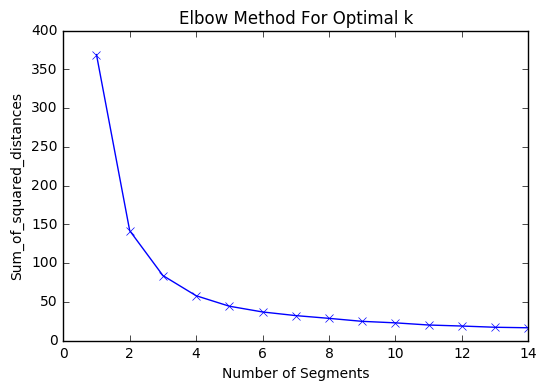

In [423]:
X_bar = []
segments = range(1,15)
for segment in segments:
    kmeans = KMeans(n_clusters=segment)
    kmeans = kmeans.fit(Feature_transformed)
    X_bar.append(kmeans.inertia_)
plt.plot(K, X_bar, 'bx-')
plt.xlabel('Number of Segments')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Based on the above elbow plot, the ideal number of segments is 3, since that points minimizes the SSD without risking overfitting

In [424]:
k = 3
kmeans = KMeans(n_clusters=3, random_state = 0).fit(Feature_transformed)
Feature_table['prediction'] = kmeans.labels_

In [425]:
Feature_table.head()

,Sum_Purchases,Count_Purchases,Count_catagories,prediction
index,,,,
1000001,333481,34,10.0,2
1000002,810353,76,5.0,1
1000003,341635,29,6.0,1
1000004,205987,13,1.0,1
1000005,821001,106,12.0,2


Final feature table with prediction, next we will analyse how well our predictions fit the data

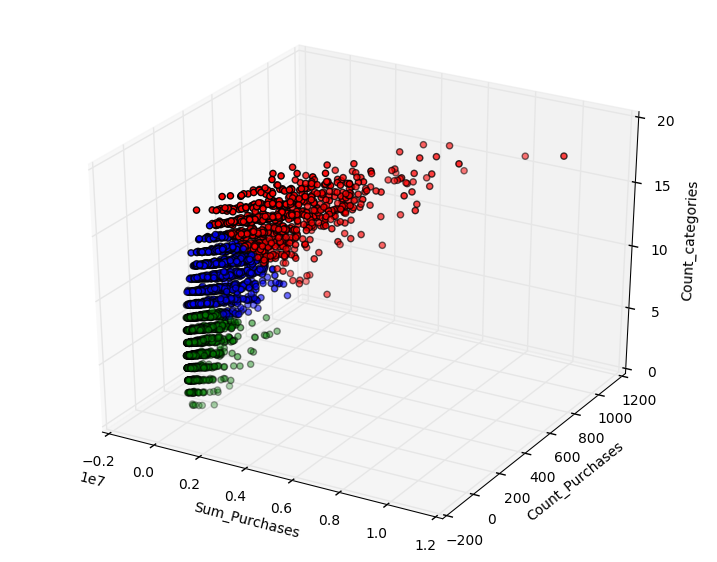

In [414]:
from mpl_toolkits.mplot3d import Axes3D
fig =  plt.figure(figsize = (9,7)).gca(projection='3d')
b = ['r', 'g', 'b']
Color_list = Feature_table['prediction'].replace(to_replace = [0, 1, 2], value = ['r', 'g', 'b']).tolist()
fig.scatter(Feature_table['Sum_Purchases'], Feature_table['Count_Purchases'], Feature_table['Count_catagories'], c = Color_list)
fig.set_xlabel('Sum_Purchases')
fig.set_ylabel('Count_Purchases')
fig.set_zlabel('Count_categories')
plt.show() 

3D plot of features colored by prediction

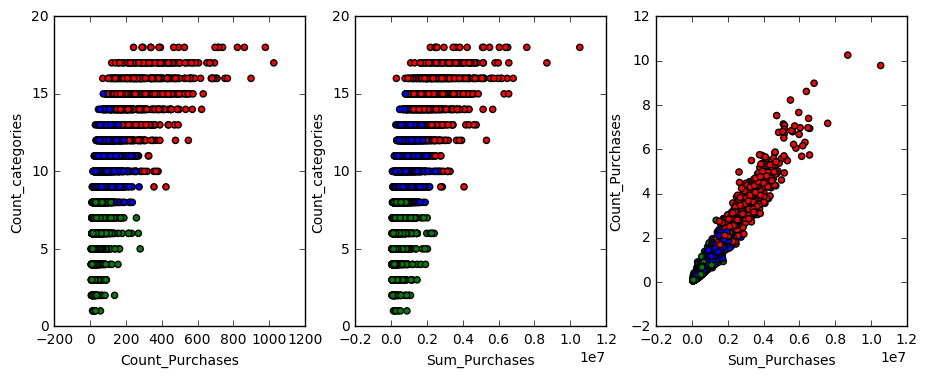

In [422]:
fig = plt.figure(figsize=(11,4))

ax1 = plt.subplot(133)
ax1.scatter(Feature_table['Sum_Purchases'], Feature_table['Count_Purchases']/100, c = Color_list)
ax1.set_xlabel('Sum_Purchases')
ax1.set_ylabel('Count_Purchases')


ax2 = plt.subplot(132)
ax2.scatter(Feature_table['Sum_Purchases'], Feature_table['Count_catagories'], c = Color_list)
ax2.set_xlabel('Sum_Purchases')
ax2.set_ylabel('Count_categories')

ax3 = plt.subplot(131)
ax3.scatter( Feature_table['Count_Purchases'], Feature_table['Count_catagories'], c = Color_list)
ax3.set_xlabel('Count_Purchases')
ax3.set_ylabel('Count_categories')

plt.show()

The above feature plots show that the segmentation identified high, medium, and low spend segment. However this first segmentation is sub-optimal since the sum of purchases and count of purchases can be seen by figure 3 to be HIGHLY correlated with a near perfect linear relationship, to the point where they can not be considered independent features. Figures 1 and 2 appear nearly identical since they are both plotted vs Count and sum, features which have been shown to be completly dependent. 
No clear segments naturally emerged from the features and so a new feature table must be created using more independent variables.